In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, LSTM, Dense, GlobalAveragePooling2D, Reshape, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

In [1]:
!unzip /content/habnet_datacube_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: habnet_datacube_data/png_images/habnet_datacube_20170306_28.3503_-80.613_0/2/04.png  
  inflating: habnet_datacube_data/png_images/habnet_datacube_20170306_28.3503_-80.613_0/2/05.png  
  inflating: habnet_datacube_data/png_images/habnet_datacube_20170306_28.3503_-80.613_0/2/06.png  
  inflating: habnet_datacube_data/png_images/habnet_datacube_20170306_28.3503_-80.613_0/2/07.png  
  inflating: habnet_datacube_data/png_images/habnet_datacube_20170306_28.3503_-80.613_0/2/08.png  
  inflating: habnet_datacube_data/png_images/habnet_datacube_20170306_28.3503_-80.613_0/2/09.png  
  inflating: habnet_datacube_data/png_images/habnet_datacube_20170306_28.3503_-80.613_0/2/10.png  
   creating: habnet_datacube_data/png_images/habnet_datacube_20170306_28.3503_-80.613_0/3/
  inflating: habnet_datacube_data/png_images/habnet_datacube_20170306_28.3503_-80.613_0/3/01.png  
  inflating: habnet_datacube_data/png_images/habnet_datacube_20170

In [5]:
df = pd.read_csv('/content/habnet_datacube_data/mvp_events.csv')
df.head()

,STATE_ID,DESCRIPTION,Unnamed: 2,LATITUDE,LONGITUDE,SAMPLE_DATE,SAMPLE_TIME,SAMPLE_DEPTH,GENUS,SPECIES,...,WIND_DIR,WIND_DIR_UNIT,WIND_DIR_QA,WIND_SPEED,WIND_SPEED_UNIT,WIND_SPEED_QA,OBJECTID,Unnamed: 27,HAB_EVENT,STABLE_EVENT_ID
0,FL,Clearwater Pass,NaN,27.96035,-82.82430,2015-02-02,19:42,0.5,Karenia,brevis,...,NaN,NaN,9,NaN,NaN,9,1745494,NaN,0,20150202_27.9604_-82.8243_0
1,FL,Big Spanish Key; 8 mi N of,NaN,24.93170,-81.40760,2015-02-24,NaN,0.2,Karenia,brevis,...,NaN,NaN,9,NaN,NaN,9,1735606,NaN,0,20150224_24.9317_-81.4076_0
2,FL,Cobbs Point (Choctawhatchee Bay),NaN,30.41147,-86.47763,2015-04-09,19:00,0.5,Karenia,brevis,...,NaN,NaN,9,NaN,NaN,9,1745881,NaN,0,20150409_30.4115_-86.4776_0
3,FL,Fourmile Point (Choctawhatchee Bay),NaN,30.40064,-86.32540,2015-04-09,18:20,0.5,Karenia,brevis,...,NaN,NaN,9,NaN,NaN,9,1752251,NaN,0,20150409_30.4006_-86.3254_0
4,FL,Siesta Beach,NaN,27.26518,-82.55310,2015-04-13,15:09,0.5,Karenia,brevis,...,NaN,NaN,9,NaN,NaN,9,1782552,NaN,0,20150413_27.2652_-82.5531_0


In [6]:
df['HAB_EVENT'] = df['HAB_EVENT'].astype('str')
df['dir_name'] = df['STABLE_EVENT_ID'].apply(lambda x : 'habnet_datacube_' + x)

In [11]:
src = '/content/habnet_datacube_data/png_images'
dest = 'data_set'
processed_labels = set()

In [14]:
import shutil
import os

processed_labels = set()

for index, row in df.iterrows():
    filename = row['dir_name']
    label = str(row['HAB_EVENT'])

    src_path = os.path.join(src, filename)
    label_dir = os.path.join(dest, label)
    dest_path = os.path.join(label_dir, filename)
    os.makedirs(label_dir, exist_ok=True)

    if os.path.exists(src_path):
        if os.path.isdir(src_path):
            if not os.path.exists(dest_path):
                shutil.copytree(src_path, dest_path)
                print(f"Directory copied: {src_path}")
            else:
                print(f"Already exists: {dest_path}")
        else:
            shutil.copy(src_path, dest_path)
            print(f"File copied: {src_path}")
    else:
        print(f"Path not found: {src_path}")

    processed_labels.add(label)

Directory copied: /content/habnet_datacube_data/png_images/habnet_datacube_20150202_27.9604_-82.8243_0
Directory copied: /content/habnet_datacube_data/png_images/habnet_datacube_20150224_24.9317_-81.4076_0
Directory copied: /content/habnet_datacube_data/png_images/habnet_datacube_20150409_30.4115_-86.4776_0
Directory copied: /content/habnet_datacube_data/png_images/habnet_datacube_20150409_30.4006_-86.3254_0
Directory copied: /content/habnet_datacube_data/png_images/habnet_datacube_20150413_27.2652_-82.5531_0
Directory copied: /content/habnet_datacube_data/png_images/habnet_datacube_20150519_27.972_-82.673_0
Directory copied: /content/habnet_datacube_data/png_images/habnet_datacube_20150625_28.0058_-84.4968_0
Directory copied: /content/habnet_datacube_data/png_images/habnet_datacube_20150819_27.6813_-82.8562_0
Directory copied: /content/habnet_datacube_data/png_images/habnet_datacube_20150830_27.838_-84.1134_0
Directory copied: /content/habnet_datacube_data/png_images/habnet_datacube_2

In [15]:
DATASET_DIR = 'data_set'
IMG_SIZE = (100, 100)
NUM_MODALITIES = 7
NUM_DAYS = 10

In [16]:
X = []
y = []

In [17]:
count = 0
for label_dir in ['0', '1']:
    label = int(label_dir)
    label_path = os.path.join(DATASET_DIR, label_dir)
    for sample_folder in os.listdir(label_path):
        sample_path = os.path.join(label_path, sample_folder)
        day_images = []
        for day in range(1, NUM_DAYS + 1):
            modalities = []
            for mod in range(1, NUM_MODALITIES + 1):
                img_path = os.path.join(sample_path, f'{mod}', f'{day:02d}.png')
                # print(img_path)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # img = cv2.resize(img, IMG_SIZE)
                    img = img.astype('float16') / 255.0
                    modalities.append(img)
                else:
                    print(f"Warning: Image not found or could not be read at {img_path}")
            if modalities: # Only append if there are valid images for the day
                day_stack = np.stack(modalities, axis=-1)
                day_images.append(day_stack)
        if day_images: # Only append if there are valid days for the sample
            sequence = np.stack(day_images, axis=0)
            X.append(sequence)
            y.append(label)

        count += 1
        print(count) # To check how many datacubes have been loaded so far

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [18]:
X = np.array(X)  # (samples, 10, 100, 100, 7)
y = np.array(y)

In [19]:
Y = to_categorical(y)

In [20]:
print(X.shape, y.shape, Y.shape)

(100, 10, 100, 100, 7) (100,) (100, 2)


In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [22]:
inputs = Input(shape=(NUM_DAYS, IMG_SIZE[0], IMG_SIZE[1], NUM_MODALITIES))  # (10, 100, 100, 7)

In [23]:
from tensorflow.keras.layers import Reshape, Lambda
# reshaped = Reshape((-1, IMG_SIZE[0], IMG_SIZE[1], NUM_MODALITIES))(inputs)


flatten_time = Lambda(lambda x: tf.reshape(x, (-1, IMG_SIZE[0], IMG_SIZE[1], NUM_MODALITIES)))
reshaped = flatten_time(inputs)

In [24]:
reshaped

<KerasTensor shape=(None, 100, 100, 7), dtype=float32, sparse=False, name=keras_tensor_3>

In [25]:
compressed = Conv2D(3, (1, 1), padding='same')(reshaped)

In [26]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
resnet.trainable = False
features = resnet(compressed)  # (batch*time, H', W', C)
features = GlobalAveragePooling2D()(features)  # (batch*time, 2048)

# Reshape back to (batch, time, features)
features_reshaped = Lambda(lambda x: tf.reshape(x, (-1, NUM_DAYS, 2048)))(features)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
x = LSTM(512, return_sequences=False)(features_reshaped)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
# output = Dense(1, activation='sigmoid')(x)
output = Dense(2, activation='softmax')(x)

In [28]:
model = Model(inputs, output)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 100, 100,   │             0 │
│                                 │ 7)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 100, 100, 7)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 3)    │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 10, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 512)            │     5,244,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,100,442 (111.01 MB)

 Trainable params: 5,510,682 (21.02 MB)

 Non-trainable params: 23,589,760 (89.99 MB)

In [30]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 130s 37s/step - accuracy: 0.5672 - loss: 1.5887 - val_accuracy: 0.4000 - val_loss: 0.7379
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 138s 36s/step - accuracy: 0.7500 - loss: 0.5418 - val_accuracy: 0.6000 - val_loss: 0.6739
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 144s 37s/step - accuracy: 0.8813 - loss: 0.2694 - val_accuracy: 0.4000 - val_loss: 0.8167
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 110s 34s/step - accuracy: 0.9531 - loss: 0.1497 - val_accuracy: 0.4000 - val_loss: 0.8864
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 111s 36s/step - accuracy: 0.9836 - loss: 0.1129 - val_accuracy: 0.4000 - val_loss: 0.8304
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 143s 35s/step - accuracy: 0.9812 - loss: 0.1324 - val_accuracy: 0.4000 - val_loss: 0.7114
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 144s 36s/step - accuracy: 0.9414 - loss: 0.1296 - val_accuracy: 0.4000 - val_loss: 0.9595
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 144s 37s/step - accuracy: 0.9656 - loss: 0.1095 - val_accuracy: 0.4000 - val_loss:

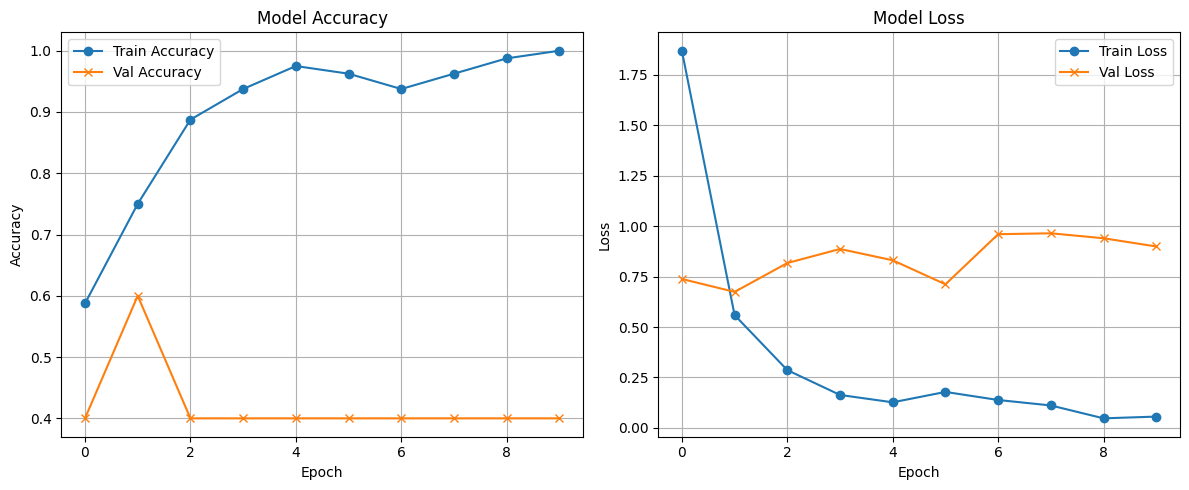

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [2]:
from keras.applications import NASNetMobile
from keras.models import Model, Sequential
from keras.layers import Flatten
from keras.applications.nasnet import preprocess_input
from keras.preprocessing import image
import numpy as np
import os
import glob
from tqdm import tqdm

_base_model = NASNetMobile(weights='imagenet', include_top=False)

_selected_layer = _base_model.layers[-1].name
print(f" Using final NASNet layer: {_selected_layer}")

_inter_model = Model(inputs=_base_model.input, outputs=_base_model.output)

class NASNetFeatureExtractor:
    def __init__(self):
        self.model = Sequential([
            _inter_model,
            Flatten()
        ])
        self.target_size = (224, 224)

    def extract(self, img_path):
        img = image.load_img(img_path, target_size=self.target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feat = self.model.predict(x, verbose=0)
        return feat[0]

def extract_features_for_sequence(sequence_dir, save_name="NASNetMobile_7x7"):
    extractor = NASNetFeatureExtractor()

    for mod_dir in tqdm(sorted(os.listdir(sequence_dir))):
        mod_path = os.path.join(sequence_dir, mod_dir)
        if not os.path.isdir(mod_path):
            continue

        pngs = sorted(glob.glob(os.path.join(mod_path, "*.png")))
        all_features = [extractor.extract(png) for png in pngs]

        np.save(os.path.join(mod_path, f"{save_name}.npy"), np.array(all_features))

    print(f" Features extracted for {os.path.basename(sequence_dir)}")


 Using final NASNet layer: activation_375


In [5]:
with open("extract_features.py", "w") as f:
    f.write("""
from keras.applications import NASNetMobile
from keras.models import Model, Sequential
from keras.layers import Flatten
from keras.applications.nasnet import preprocess_input
from keras.preprocessing import image
import numpy as np
import os
import glob
from tqdm import tqdm

_base_model = NASNetMobile(weights='imagenet', include_top=False)

_selected_layer = _base_model.layers[-1].name
print(f" Using final NASNet layer: {_selected_layer}")

_inter_model = Model(inputs=_base_model.input, outputs=_base_model.output)

class NASNetFeatureExtractor:
    def __init__(self):
        self.model = Sequential([
            _inter_model,
            Flatten()
        ])
        self.target_size = (224, 224)

    def extract(self, img_path):
        img = image.load_img(img_path, target_size=self.target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feat = self.model.predict(x, verbose=0)
        return feat[0]

def extract_features_for_sequence(sequence_dir, save_name="NASNetMobile_7x7"):
    extractor = NASNetFeatureExtractor()

    for mod_dir in tqdm(sorted(os.listdir(sequence_dir))):
        mod_path = os.path.join(sequence_dir, mod_dir)
        if not os.path.isdir(mod_path):
            continue

        pngs = sorted(glob.glob(os.path.join(mod_path, "*.png")))
        all_features = [extractor.extract(png) for png in pngs]

        np.save(os.path.join(mod_path, f"{save_name}.npy"), np.array(all_features))

    print(f" Features extracted for {os.path.basename(sequence_dir)}")

""")


In [6]:
from extract_features import extract_features_for_sequence
import os

base_dir = "/content/habnet_datacube_data/png_images"
sequences = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

for seq in sequences:
    extract_features_for_sequence(seq)


 Using final NASNet layer: activation_563


100%|██████████| 7/7 [00:25<00:00,  3.59s/it]


 Features extracted for habnet_datacube_20160322_27.5967_-82.6055_0


100%|██████████| 7/7 [00:22<00:00,  3.20s/it]


 Features extracted for habnet_datacube_20180821_26.8963_-82.3406_260667


100%|██████████| 7/7 [00:23<00:00,  3.38s/it]


 Features extracted for habnet_datacube_20180110_29.683_-85.2377_0


100%|██████████| 7/7 [00:23<00:00,  3.36s/it]


 Features extracted for habnet_datacube_20180529_27.6055_-82.6508_0


100%|██████████| 7/7 [00:22<00:00,  3.23s/it]


 Features extracted for habnet_datacube_20170424_27.2184_-82.5171_0


100%|██████████| 7/7 [00:23<00:00,  3.29s/it]


 Features extracted for habnet_datacube_20151005_30.1241_-85.631_322333


100%|██████████| 7/7 [00:25<00:00,  3.66s/it]


 Features extracted for habnet_datacube_20180823_26.6656_-82.2208_700500


100%|██████████| 7/7 [00:26<00:00,  3.80s/it]


 Features extracted for habnet_datacube_20161005_27.1342_-82.4705_312000


100%|██████████| 7/7 [00:25<00:00,  3.65s/it]


 Features extracted for habnet_datacube_20151202_27.2935_-82.5468_199000


100%|██████████| 7/7 [00:25<00:00,  3.65s/it]


 Features extracted for habnet_datacube_20171016_26.7824_-82.2094_0


100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


 Features extracted for habnet_datacube_20150922_26.7967_-82.5785_0


100%|██████████| 7/7 [00:23<00:00,  3.31s/it]


 Features extracted for habnet_datacube_20150625_28.0058_-84.4968_0


100%|██████████| 7/7 [00:25<00:00,  3.62s/it]


 Features extracted for habnet_datacube_20151103_29.831_-85.3477_69333


100%|██████████| 7/7 [00:23<00:00,  3.37s/it]


 Features extracted for habnet_datacube_20170619_26.3048_-81.8362_0


100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


 Features extracted for habnet_datacube_20181210_27.4959_-82.6522_460168


100%|██████████| 7/7 [00:23<00:00,  3.34s/it]


 Features extracted for habnet_datacube_20180629_25.9715_-81.7212_479972


100%|██████████| 7/7 [00:24<00:00,  3.56s/it]


 Features extracted for habnet_datacube_20170410_25.9124_-81.7171_0


100%|██████████| 7/7 [00:28<00:00,  4.01s/it]


 Features extracted for habnet_datacube_20180516_25.6817_-81.3579_0


100%|██████████| 7/7 [00:28<00:00,  4.03s/it]


 Features extracted for habnet_datacube_20170124_27.2982_-82.5674_238000


100%|██████████| 7/7 [00:25<00:00,  3.66s/it]


 Features extracted for habnet_datacube_20171219_24.9436_-81.3729_0


100%|██████████| 7/7 [00:24<00:00,  3.54s/it]


 Features extracted for habnet_datacube_20180604_26.6178_-82.5027_0


100%|██████████| 7/7 [00:25<00:00,  3.62s/it]


 Features extracted for habnet_datacube_20180827_27.4959_-82.6522_0


100%|██████████| 7/7 [00:23<00:00,  3.38s/it]


 Features extracted for habnet_datacube_20180821_26.9167_-82.3667_399333


100%|██████████| 7/7 [00:23<00:00,  3.33s/it]


 Features extracted for habnet_datacube_20180926_26.3019_-81.9597_125333


100%|██████████| 7/7 [00:26<00:00,  3.82s/it]


 Features extracted for habnet_datacube_20171218_26.5992_-82.1846_66333


100%|██████████| 7/7 [00:28<00:00,  4.10s/it]


 Features extracted for habnet_datacube_20150224_24.9317_-81.4076_0


100%|██████████| 7/7 [00:26<00:00,  3.73s/it]


 Features extracted for habnet_datacube_20181016_30.4232_-86.183_0


100%|██████████| 7/7 [00:23<00:00,  3.38s/it]


 Features extracted for habnet_datacube_20161205_26.55_-82.1958_225717


100%|██████████| 7/7 [00:23<00:00,  3.33s/it]


 Features extracted for habnet_datacube_20180404_26.331_-81.8457_274740


100%|██████████| 7/7 [00:25<00:00,  3.69s/it]


 Features extracted for habnet_datacube_20180613_28.5264_-80.7391_0


100%|██████████| 7/7 [00:23<00:00,  3.40s/it]


 Features extracted for habnet_datacube_20161128_27.2184_-82.5171_778000


100%|██████████| 7/7 [00:25<00:00,  3.67s/it]


 Features extracted for habnet_datacube_20170710_30.1144_-85.6833_0


100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


 Features extracted for habnet_datacube_20170816_27.3316_-82.5779_0


100%|██████████| 7/7 [00:26<00:00,  3.79s/it]


 Features extracted for habnet_datacube_20180219_27.2248_-80.2113_0


100%|██████████| 7/7 [00:26<00:00,  3.75s/it]


 Features extracted for habnet_datacube_20160217_29.41_-83.3073_0


100%|██████████| 7/7 [00:26<00:00,  3.77s/it]


 Features extracted for habnet_datacube_20170106_27.3338_-82.5794_101000


100%|██████████| 7/7 [00:23<00:00,  3.31s/it]


 Features extracted for habnet_datacube_20151207_27.7494_-82.7525_713333


100%|██████████| 7/7 [00:23<00:00,  3.30s/it]


 Features extracted for habnet_datacube_20180626_26.8164_-82.2749_848383


100%|██████████| 7/7 [00:25<00:00,  3.68s/it]


 Features extracted for habnet_datacube_20151012_27.1233_-82.4712_851000


100%|██████████| 7/7 [00:24<00:00,  3.43s/it]


 Features extracted for habnet_datacube_20180814_29.3102_-83.1993_0


100%|██████████| 7/7 [00:24<00:00,  3.45s/it]


 Features extracted for habnet_datacube_20170821_26.3048_-81.8362_0


100%|██████████| 7/7 [00:23<00:00,  3.39s/it]


 Features extracted for habnet_datacube_20170515_26.5902_-82.1561_0


100%|██████████| 7/7 [00:25<00:00,  3.70s/it]


 Features extracted for habnet_datacube_20160731_24.5977_-81.4545_0


100%|██████████| 7/7 [00:24<00:00,  3.43s/it]


 Features extracted for habnet_datacube_20161017_27.5385_-82.7402_868700


100%|██████████| 7/7 [00:23<00:00,  3.39s/it]


 Features extracted for habnet_datacube_20150819_27.6813_-82.8562_0


100%|██████████| 7/7 [00:23<00:00,  3.42s/it]


 Features extracted for habnet_datacube_20180821_27.6985_-82.7382_57333


100%|██████████| 7/7 [00:23<00:00,  3.37s/it]


 Features extracted for habnet_datacube_20161115_27.7158_-82.7107_67333


100%|██████████| 7/7 [00:25<00:00,  3.67s/it]


 Features extracted for habnet_datacube_20181002_26.4469_-80.0658_0


100%|██████████| 7/7 [00:24<00:00,  3.45s/it]


 Features extracted for habnet_datacube_20170726_28.4751_-80.7665_0


100%|██████████| 7/7 [00:24<00:00,  3.45s/it]


 Features extracted for habnet_datacube_20181031_26.3504_-80.069_0


100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


 Features extracted for habnet_datacube_20180605_30.0367_-84.1667_0


100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


 Features extracted for habnet_datacube_20180122_27.949_-82.561_0


100%|██████████| 7/7 [00:25<00:00,  3.66s/it]


 Features extracted for habnet_datacube_20151130_27.311_-82.5772_290000


100%|██████████| 7/7 [00:25<00:00,  3.62s/it]


 Features extracted for habnet_datacube_20150202_27.9604_-82.8243_0


100%|██████████| 7/7 [00:25<00:00,  3.58s/it]


 Features extracted for habnet_datacube_20180628_26.4163_-82.2026_114000


100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


 Features extracted for habnet_datacube_20181105_27.446_-82.688_1091122


100%|██████████| 7/7 [00:23<00:00,  3.35s/it]


 Features extracted for habnet_datacube_20180113_25.9124_-81.7171_0


100%|██████████| 7/7 [00:23<00:00,  3.34s/it]


 Features extracted for habnet_datacube_20180718_27.0672_-82.4486_3907233


100%|██████████| 7/7 [00:24<00:00,  3.44s/it]


 Features extracted for habnet_datacube_20150519_27.972_-82.673_0


100%|██████████| 7/7 [00:26<00:00,  3.77s/it]


 Features extracted for habnet_datacube_20170306_28.3503_-80.613_0


100%|██████████| 7/7 [00:24<00:00,  3.47s/it]


 Features extracted for habnet_datacube_20160920_27.3338_-82.5794_156000


100%|██████████| 7/7 [00:23<00:00,  3.39s/it]


 Features extracted for habnet_datacube_20180823_26.776_-82.3456_76333


100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


 Features extracted for habnet_datacube_20181113_27.4621_-82.6992_203573


100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


 Features extracted for habnet_datacube_20181205_27.1405_-82.4718_73000


100%|██████████| 7/7 [00:25<00:00,  3.62s/it]


 Features extracted for habnet_datacube_20170809_29.7184_-85.3231_0


100%|██████████| 7/7 [00:23<00:00,  3.40s/it]


 Features extracted for habnet_datacube_20160203_27.3536_-82.5739_66000


100%|██████████| 7/7 [00:23<00:00,  3.39s/it]


 Features extracted for habnet_datacube_20180108_26.5604_-82.1708_636677


100%|██████████| 7/7 [00:24<00:00,  3.43s/it]


 Features extracted for habnet_datacube_20181031_26.6488_-82.5191_99669


100%|██████████| 7/7 [00:25<00:00,  3.71s/it]


 Features extracted for habnet_datacube_20171127_26.5321_-82.1567_124342


100%|██████████| 7/7 [00:23<00:00,  3.42s/it]


 Features extracted for habnet_datacube_20180917_26.4269_-82.1345_2737140


100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


 Features extracted for habnet_datacube_20181014_26.6441_-82.0558_0


100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


 Features extracted for habnet_datacube_20170414_27.3338_-82.5794_0


100%|██████████| 7/7 [00:23<00:00,  3.36s/it]


 Features extracted for habnet_datacube_20171016_27.0103_-82.4131_0


100%|██████████| 7/7 [00:25<00:00,  3.67s/it]


 Features extracted for habnet_datacube_20170124_26.8162_-82.2805_75183


100%|██████████| 7/7 [00:23<00:00,  3.42s/it]


 Features extracted for habnet_datacube_20150830_27.838_-84.1134_0


100%|██████████| 7/7 [00:24<00:00,  3.47s/it]


 Features extracted for habnet_datacube_20180314_26.8056_-82.2742_441056


100%|██████████| 7/7 [00:25<00:00,  3.64s/it]


 Features extracted for habnet_datacube_20181107_27.3871_-82.6252_862000


100%|██████████| 7/7 [00:25<00:00,  3.59s/it]


 Features extracted for habnet_datacube_20180917_26.4866_-82.2282_83282


100%|██████████| 7/7 [00:23<00:00,  3.41s/it]


 Features extracted for habnet_datacube_20170313_26.8162_-82.2805_68667


100%|██████████| 7/7 [00:23<00:00,  3.40s/it]


 Features extracted for habnet_datacube_20160929_26.2538_-81.8238_0


100%|██████████| 7/7 [00:23<00:00,  3.39s/it]


 Features extracted for habnet_datacube_20160705_27.311_-82.5772_0


100%|██████████| 7/7 [00:26<00:00,  3.83s/it]


 Features extracted for habnet_datacube_20181022_27.5208_-80.3095_1601320


100%|██████████| 7/7 [00:25<00:00,  3.64s/it]


 Features extracted for habnet_datacube_20150409_30.4006_-86.3254_0


100%|██████████| 7/7 [00:23<00:00,  3.39s/it]


 Features extracted for habnet_datacube_20171002_27.9041_-82.4892_0


100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


 Features extracted for habnet_datacube_20170308_29.6663_-81.2107_0


100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


 Features extracted for habnet_datacube_20161207_27.2504_-82.529_70000


100%|██████████| 7/7 [00:35<00:00,  5.12s/it]


 Features extracted for habnet_datacube_20181120_26.1128_-81.8121_913000


100%|██████████| 7/7 [00:25<00:00,  3.67s/it]


 Features extracted for habnet_datacube_20181119_27.2065_-82.5757_1864000


100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


 Features extracted for habnet_datacube_20181126_27.1236_-82.4715_1292033


100%|██████████| 7/7 [00:23<00:00,  3.38s/it]


 Features extracted for habnet_datacube_20151216_26.4516_-82.0154_0


100%|██████████| 7/7 [00:25<00:00,  3.68s/it]


 Features extracted for habnet_datacube_20161025_27.0128_-82.4698_718000


100%|██████████| 7/7 [00:25<00:00,  3.67s/it]


 Features extracted for habnet_datacube_20151130_27.3316_-82.5779_621000


100%|██████████| 7/7 [00:24<00:00,  3.43s/it]


 Features extracted for habnet_datacube_20161102_27.3513_-82.5566_92000


100%|██████████| 7/7 [00:25<00:00,  3.67s/it]


 Features extracted for habnet_datacube_20170814_25.8815_-81.6322_0


100%|██████████| 7/7 [00:25<00:00,  3.65s/it]


 Features extracted for habnet_datacube_20160314_24.7653_-81.6565_0


100%|██████████| 7/7 [00:26<00:00,  3.74s/it]


 Features extracted for habnet_datacube_20180822_27.0575_-82.4438_6535324


100%|██████████| 7/7 [00:25<00:00,  3.65s/it]


 Features extracted for habnet_datacube_20150409_30.4115_-86.4776_0


100%|██████████| 7/7 [00:25<00:00,  3.66s/it]


 Features extracted for habnet_datacube_20150413_27.2652_-82.5531_0


100%|██████████| 7/7 [00:23<00:00,  3.37s/it]


 Features extracted for habnet_datacube_20180808_27.3534_-82.5623_1262000


100%|██████████| 7/7 [00:26<00:00,  3.74s/it]

 Features extracted for habnet_datacube_20181014_26.4263_-81.9602_0


In [1]:
import numpy as np
import os
from tensorflow.keras.utils import Sequence

class HABDataset(Sequence):
    def __init__(self, data_dirs, labels, time_steps=10, batch_size=32, shuffle=True):
        self.data_dirs = data_dirs
        self.labels = labels
        self.time_steps = time_steps
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data_dirs) / self.batch_size))

    def __getitem__(self, idx):
        batch_dirs = self.data_dirs[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        X = []
        for seq_dir in batch_dirs:
            modality_features = []
            for mod in sorted(os.listdir(seq_dir)):
                path = os.path.join(seq_dir, mod, "NASNetMobile_7x7.npy")
                if os.path.exists(path):
                    modality_features.append(np.load(path))
            modality_features = np.stack(modality_features, axis=-1)
            modality_features = modality_features.reshape(modality_features.shape[0], -1)
            X.append(modality_features[:self.time_steps])

        forecast_horizon = 9
        y = np.repeat(np.array(batch_labels)[:, np.newaxis], forecast_horizon, axis=1)

        return np.array(X), y

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.data_dirs, self.labels))
            np.random.shuffle(temp)
            self.data_dirs, self.labels = zip(*temp)


In [2]:
with open("dataset.py", "w") as f: f.write('''import numpy as np
import os
from tensorflow.keras.utils import Sequence

class HABDataset(Sequence):
    def __init__(self, data_dirs, labels, time_steps=10, batch_size=32, shuffle=True):
        self.data_dirs = data_dirs
        self.labels = labels
        self.time_steps = time_steps
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data_dirs) / self.batch_size))

    def __getitem__(self, idx):
        batch_dirs = self.data_dirs[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        X = []
        for seq_dir in batch_dirs:
            modality_features = []
            for mod in sorted(os.listdir(seq_dir)):
                path = os.path.join(seq_dir, mod, "NASNetMobile_7x7.npy")
                if os.path.exists(path):
                    modality_features.append(np.load(path))
            modality_features = np.stack(modality_features, axis=-1)  # [T, F, C]
            modality_features = modality_features.reshape(modality_features.shape[0], -1)  # [T, F*C]
            X.append(modality_features[:self.time_steps])

        forecast_horizon = 9  # Make sure this matches your model
        y = np.repeat(np.array(batch_labels)[:, np.newaxis], forecast_horizon, axis=1)  # (batch, 9)

        return np.array(X), y

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.data_dirs, self.labels))
            np.random.shuffle(temp)
            self.data_dirs, self.labels = zip(*temp)

''')


In [3]:
import os
from sklearn.model_selection import train_test_split

data_root = "/content/habnet_datacube_data/png_images"
sequence_dirs = [os.path.join(data_root, d) for d in os.listdir(data_root)]
labels = [1 if "_1" in d else 0 for d in sequence_dirs]

train_dirs, val_dirs, y_train, y_val = train_test_split(sequence_dirs, labels, test_size=0.2, random_state=42)


In [4]:
from dataset import HABDataset

train_gen = HABDataset(train_dirs, y_train, time_steps=10)
X_sample, _ = train_gen[0]
print(X_sample.shape)


(32, 10, 362208)


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense

def build_lstm_model(input_shape, forecast_horizon=9):
    print("Using input shape:", input_shape)  # Confirm it's (10, feature_dim)

    inp = Input(shape=input_shape)
    x = LSTM(128, return_sequences=False)(inp)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(forecast_horizon, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [6]:
with open("models.py", "w") as f: f.write('''
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense

def build_lstm_model(input_shape, forecast_horizon=9):
    print("Using input shape:", input_shape)  # Confirm it's (10, feature_dim)

    inp = Input(shape=input_shape)
    x = LSTM(128, return_sequences=False)(inp)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(forecast_horizon, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

''')


In [7]:
from dataset import HABDataset
from models import build_lstm_model
from sklearn.model_selection import train_test_split
import numpy as np
import os

data_root = "/content/habnet_datacube_data/png_images"
sequence_dirs = [os.path.join(data_root, d) for d in os.listdir(data_root)]
labels = [1 if "_1" in d else 0 for d in sequence_dirs]

train_dirs, val_dirs, y_train, y_val = train_test_split(sequence_dirs, labels, test_size=0.2, random_state=42)

train_gen = HABDataset(train_dirs, y_train, time_steps=10)
val_gen = HABDataset(val_dirs, y_val, time_steps=10)

X_sample, y_sample = train_gen[0]
input_shape = X_sample.shape[1:]
print("Model input shape:", input_shape)
print("Target shape:", y_sample.shape)

model = build_lstm_model(input_shape=input_shape, forecast_horizon=9)
model.fit(train_gen, validation_data=val_gen, epochs=10)

model.save("hab_forecast_model.h5")


Model input shape: (10, 362208)
Target shape: (32, 9)
Using input shape: (10, 362208)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 50s 17s/step - accuracy: 0.0000e+00 - loss: 0.5795 - val_accuracy: 0.0000e+00 - val_loss: 0.2730
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 14s/step - accuracy: 0.0000e+00 - loss: 0.4378 - val_accuracy: 0.0000e+00 - val_loss: 0.2294
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 93s 20s/step - accuracy: 0.0000e+00 - loss: 0.4355 - val_accuracy: 0.0000e+00 - val_loss: 0.2005
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 44s 16s/step - accuracy: 0.0000e+00 - loss: 0.4325 - val_accuracy: 0.0000e+00 - val_loss: 0.1760
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 15s/step - accuracy: 0.0000e+00 - loss: 0.3844 - val_accuracy: 0.0000e+00 - val_loss: 0.1553
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 84s 15s/step - accuracy: 0.0281 - loss: 0.4369 - val_accuracy: 0.0000e+00 - val_loss: 0.1391
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 52s 17s/step - accuracy: 0.0000e+00 - loss: 0.4038 - val_accuracy: 0.0000e+00 - val_loss: 0.1238
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.0523 - los

In [8]:
from tensorflow.keras.models import load_model
import numpy as np
import os

def forecast_from_sequence(sequence_dir, model_path="hab_forecast_model.h5", threshold=0.5):
    model = load_model(model_path)

    modality_features = []
    for mod in sorted(os.listdir(sequence_dir)):
        path = os.path.join(sequence_dir, mod, "NASNetMobile_7x7.npy")
        if os.path.exists(path):
            modality_features.append(np.load(path))
    modality_features = np.stack(modality_features, axis=-1)
    sequence = modality_features[:10]

    pred = model.predict(np.expand_dims(sequence, axis=0))[0]

    for day, p in enumerate(pred):
        prob = float(p[0])
        alert = " WARNING" if prob > threshold else "Safe"
        print(f"Day {day}: {prob:.2f} → {alert}")


In [9]:
from tensorflow.keras.models import load_model

model = load_model("hab_forecast_model.h5")


In [11]:
from dataset import HABDataset
import numpy as np
import os

sequence_to_predict = val_dirs[0]

sample_dataset = HABDataset([sequence_to_predict], [0], time_steps=10, shuffle=False)

X_input, _ = sample_dataset[0]


In [12]:
prediction = model.predict(X_input)
print("Raw prediction (probabilities for 9 days):", prediction[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Raw prediction (probabilities for 9 days): [0.08209335 0.07963726 0.09671726 0.09886689 0.09190484 0.09339684
 0.09304421 0.0792703  0.10583375]


In [13]:
threshold = 0.5
binary_forecast = (prediction[0] > threshold).astype(int)
print("Binary forecast (1 = HAB):", binary_forecast)


Binary forecast (1 = HAB): [0 0 0 0 0 0 0 0 0]


In [18]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from datetime import datetime, timedelta

# --- User Input ---
realtime_seq_dir = "/content/habnet_datacube_data/png_images/habnet_datacube_20150202_27.9604_-82.8243_0"
start_date_str = "2015-02-02"
forecast_horizon = 9

# --- Load model ---
model = load_model("hab_forecast_model.h5")

# --- Load features ---
modality_features = []
for mod in sorted(os.listdir(realtime_seq_dir)):
    path = os.path.join(realtime_seq_dir, mod, "NASNetMobile_7x7.npy")
    if os.path.exists(path):
        modality_features.append(np.load(path))

modality_features = np.stack(modality_features, axis=-1)
modality_features = modality_features.reshape(modality_features.shape[0], -1)
modality_features = modality_features[:10]
X_input = np.expand_dims(modality_features, axis=0)

# --- Predict ---
probs = model.predict(X_input)[0]

# --- Format & Display ---
start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
print("Forecast for next 9 days:")
for i, prob in enumerate(probs):
    date = (start_date + timedelta(days=i)).strftime("%Y-%m-%d")
    percentage = prob * 100
    if percentage >= 55:
        risk = " WARNING"
    elif percentage >= 40:
        risk = " Low Risk"
    else:
        risk = " No Risk"
    print(f"{date} — {percentage:.1f}% chance of HAB — {risk}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
Forecast for next 9 days:
2015-02-02 — 9.2% chance of HAB —  No Risk
2015-02-03 — 7.7% chance of HAB —  No Risk
2015-02-04 — 10.1% chance of HAB —  No Risk
2015-02-05 — 11.3% chance of HAB —  No Risk
2015-02-06 — 7.8% chance of HAB —  No Risk
2015-02-07 — 10.9% chance of HAB —  No Risk
2015-02-08 — 8.9% chance of HAB —  No Risk
2015-02-09 — 8.1% chance of HAB —  No Risk
2015-02-10 — 11.3% chance of HAB —  No Risk
